In [2]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import math
from qiskit_aer import AerSimulator
from sklearn.preprocessing import normalize

Create a random sample of which we will take the Fourier transform:

In [3]:
sample = np.random.rand(16)
sample_norm = normalize(sample.reshape(1, -1), norm='l2')[0]

Calculate the number of qubits needed for the normalized sample:

In [4]:
n = len(sample_norm)
q = int(math.log(n,2))
f"Num qubits: {q}"

'Num qubits: 4'

Create a quantum circuit, add QFT with swaps to this circuit:

In [5]:
circuit = qiskit.QuantumCircuit(q)
circuit.initialize(sample_norm, range(q))

In [6]:
qft = qiskit.circuit.library.QFT(num_qubits=q, do_swaps=True)
circuit.compose(qft, inplace=True)
circuit.save_statevector()

Simulate using Aer to get the result of the statevector:

In [7]:
backend = AerSimulator()
result = backend.run(circuit.decompose(reps=16)).result()
qft_state = result.get_statevector()

Compare the power spectral density of the QFT vs the classical FFT to check our result:

In [8]:
PSD_q = np.abs(qft_state)**2

In [9]:
f = sample_norm
fhat = np.fft.fft(f, n)
PSD = np.abs(fhat)**2 / n

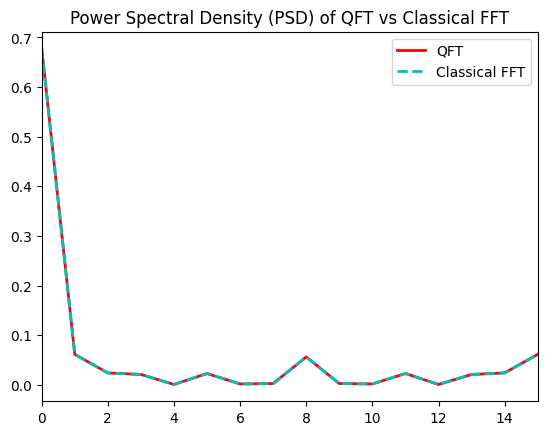

In [10]:
plt.title('Power Spectral Density (PSD) of QFT vs Classical FFT')
plt.plot(PSD_q, color='r', linewidth=2, label='QFT')
plt.plot(PSD, color='c', linestyle='dashed', linewidth=2, label='Classical FFT')
plt.xlim(0, n-1)
plt.legend()
plt.show()

The QFT circuit is the following:

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


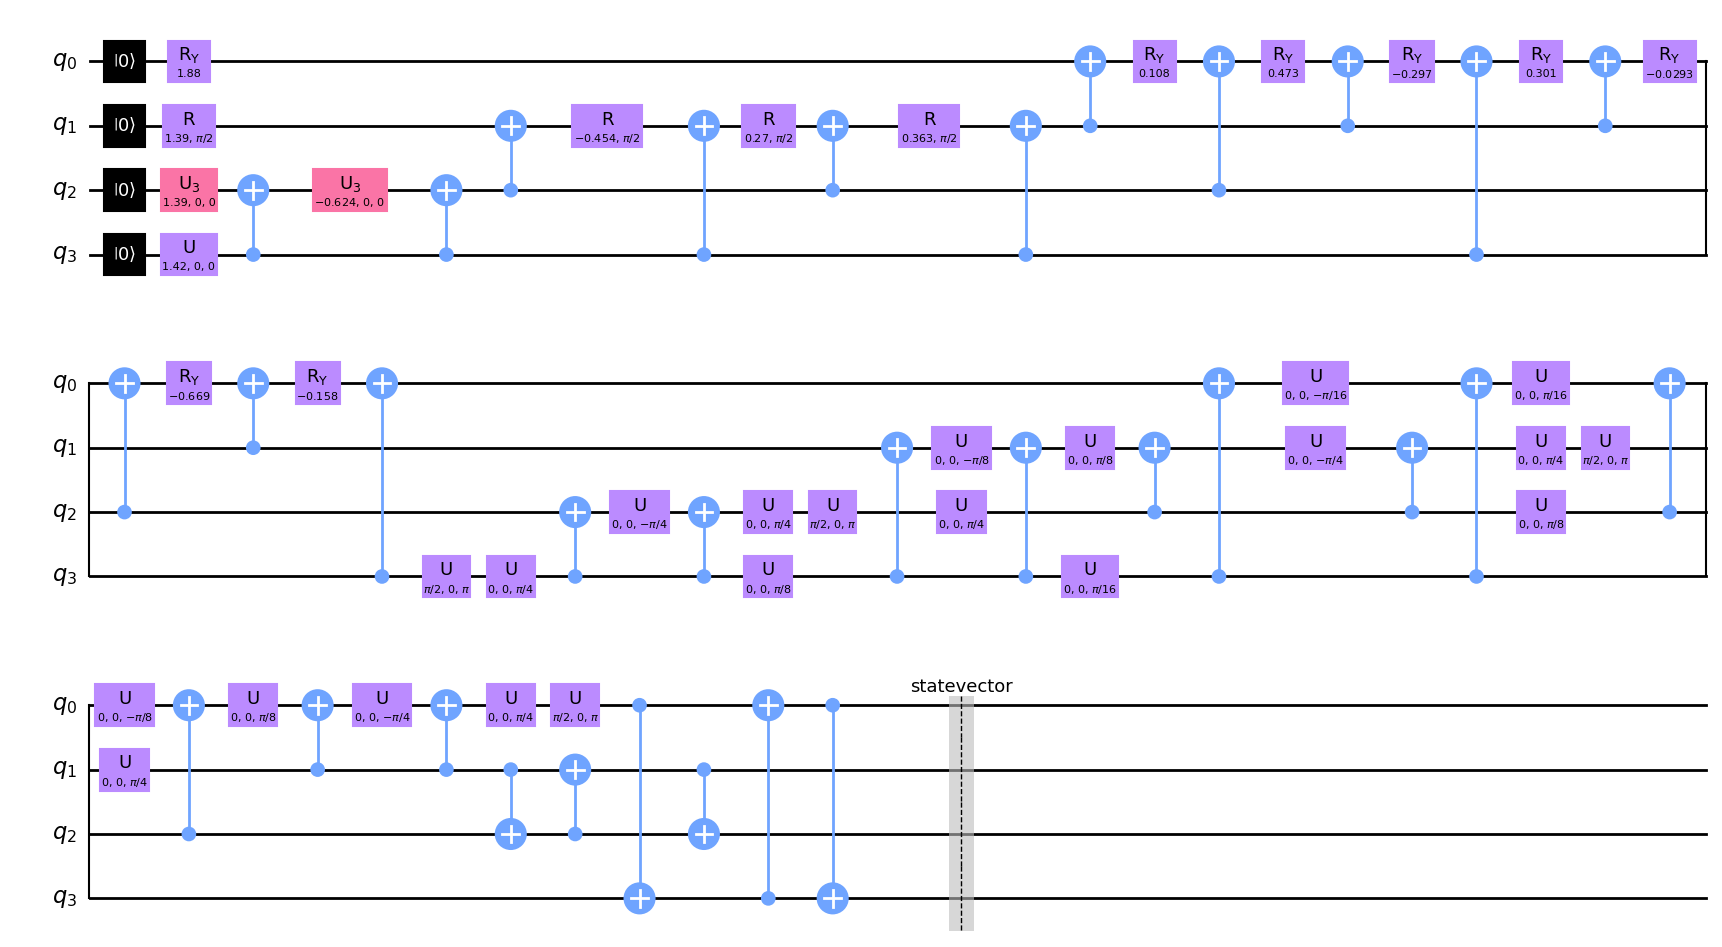

In [11]:
circuit = circuit.decompose(reps=7)

circuit.draw('mpl')

We would like to cut this circuit.

In [12]:
from qiskit.circuit.random import random_circuit

from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import execute_simulation
from circuit_knitting.cutting.cutting_reconstruction import reconstruct_expectation_values
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import exact_observables
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import compare_results

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


We would like to measure in the Z basis, and without initializing any data, to test cuts on the QFT subroutine only:

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


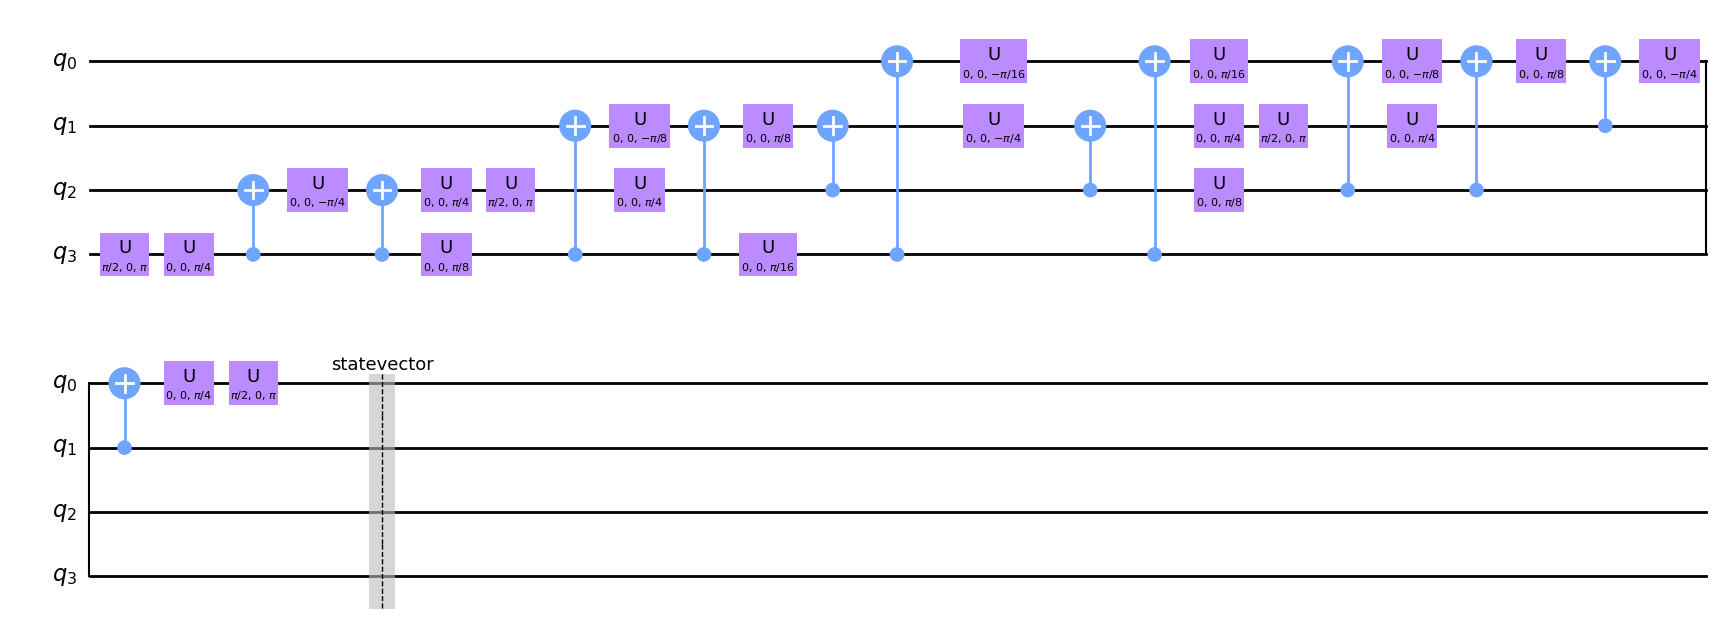

In [14]:
circuit = qiskit.QuantumCircuit(q)
qft = qiskit.circuit.library.QFT(num_qubits=q, do_swaps=False)
circuit.compose(qft, inplace=True)
circuit.save_statevector()
circuit = circuit.decompose(reps=7)
circuit.draw('mpl')

In [15]:
observables = ['Z'*circuit.num_qubits]

In [20]:
subcircuits, subobservables = cut_wires_and_gates_to_subcircuits(
    circuit=circuit,
    observables=observables,
    method='automatic',
    max_subcircuit_width=2,
    max_cuts=100,
    num_subcircuits=[2],
    model='gurobi'
)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 313 rows, 135 columns and 1054 nonzeros
Model fingerprint: 0x3aa198d6
Variable types: 0 continuous, 135 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 2e+00]
Presolve removed 313 rows and 135 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 8 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.000000000000e+00, best bound 8.000000000000e+00, gap 0.0000%
MIP MODEL CU

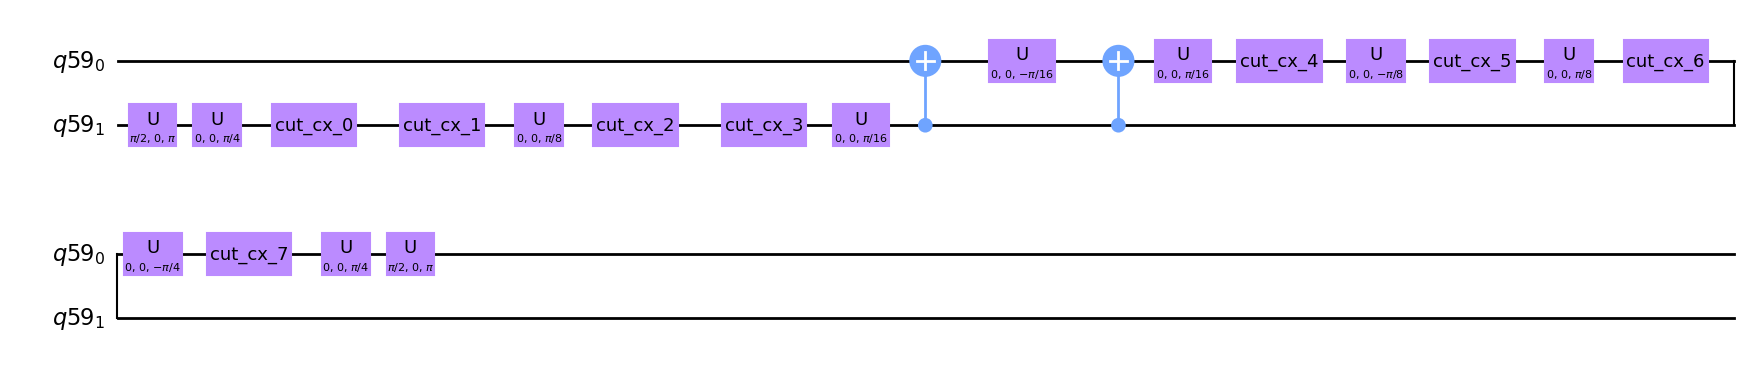

In [21]:
subcircuits[0].draw('mpl')

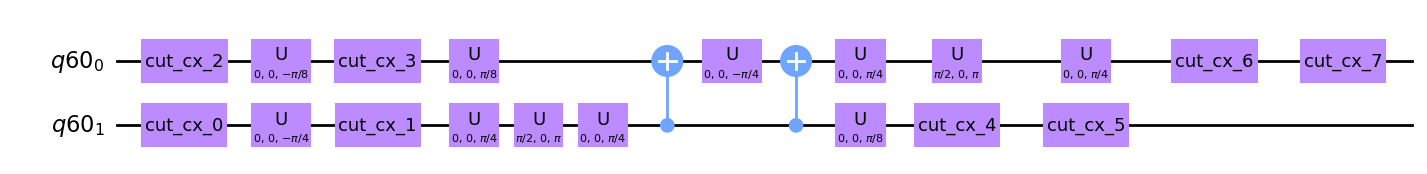

In [22]:
subcircuits[1].draw('mpl')